In [1]:
from transformers import (
    AutoFeatureExtractor, 
    AutoTokenizer, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer, 
    default_data_collator,
)

from torch.utils.data import Dataset

import pandas as pd
from sklearn.model_selection import train_test_split

from pathlib import Path
from PIL import Image

import pandas as pd 

2024-08-13 11:02:24.053771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 11:02:24.053874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 11:02:24.190057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:


df2 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
df1 = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')



In [3]:
df2.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [4]:
df1.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [5]:
df1["findings"][0]

'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.'

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

In [7]:
img=cv2.imread("/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-1001.dcm.png")


In [8]:
images_captions_df = pd.DataFrame({'imgs': [],
                                    'captions': []})
for i in range(len(df2)):
    uid = df2.iloc[i]['uid']
    image = df2.iloc[i]['filename']
    index = df1.loc[df1['uid'] ==uid]
    
    if not index.empty:    
        index = index.index[0]
        caption = df1.iloc[index]['findings']
        if type(caption) == float:
         
            continue 
        images_captions_df = pd.concat([images_captions_df, pd.DataFrame([{'imgs': image, 'captions': caption}])], ignore_index=True)
images_captions_df.head()


,imgs,captions
0,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size ar...
1,1_IM-0001-3001.dcm.png,The cardiac silhouette and mediastinum size ar...
2,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...
3,2_IM-0652-2001.dcm.png,Borderline cardiomegaly. Midline sternotomy XX...
4,4_IM-2050-1001.dcm.png,There are diffuse bilateral interstitial and a...


In [9]:
p = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
images_captions_df['imgs'] = p+ images_captions_df['imgs']
images_captions_df.head()

,imgs,captions
0,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
2,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
3,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
4,/kaggle/input/chest-xrays-indiana-university/i...,There are diffuse bilateral interstitial and a...


In [10]:

encoder_checkpoint = "google/vit-base-patch16-224-in21k"
decoder_checkpoint = "gpt2"

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(decoder_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

# maximum length for the captions
max_length = 512

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
class LoadDataset(Dataset):
    def __init__(self, df):
        self.images = df['imgs'].values
        self.captions = df['captions'].values

    
    def __getitem__(self, idx):
        # everything to return is stored inside this dict
        inputs = dict()

        # load the image and apply feature_extractor
        image_path = str(self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = feature_extractor(images=image, return_tensors='pt')

        # load the caption and apply tokenizer
        caption = self.captions[idx]
        labels = tokenizer(
            caption, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length',
            return_tensors='pt',
        )['input_ids'][0]
        
        # store the inputs and labels in the dict we created
        inputs['pixel_values'] = image['pixel_values'].squeeze()   
        inputs['labels'] = labels
        return inputs
    
    def __len__(self):
        return len(self.images)

In [12]:
train_,test_df =train_test_split(images_captions_df, test_size=0.10, shuffle=True, random_state=42)
train_df,val_df =train_test_split(train_, test_size=0.10, shuffle=True, random_state=42)

In [13]:
train_ds = LoadDataset(train_df)
test_ds = LoadDataset(test_df)
val_ds = LoadDataset(val_df)

# Inference

In [14]:
import torch

# Load model trained 
FILE = '/kaggle/input/visionencoderdecoder-final/model.pth'
loaded_mode = torch.load(FILE)
# loaded_mode.eval()

In [15]:
import torch
import matplotlib.pyplot as plt

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


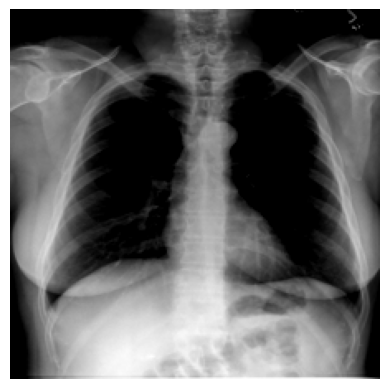

In [16]:
inputs = val_ds[43]['pixel_values']
# model.eval()
with torch.no_grad():
    # uncomment the below line if feature extractor is not applied to the image already
    # inputs = feature_extractor(images=inputs, return_tensors='pt').pixel_values

    # model prediction 
    out = loaded_mode.generate(
        inputs.unsqueeze(0).to('cuda'), # move inputs to GPU
        num_beams=4, 
        max_length=512
        )


plt.axis('off')
plt.imshow(torch.permute(inputs, (1, 2, 0)));
# convert token ids to string format
decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)
print(decoded_out)


# Show Original and Actual Imgs¶


In [17]:
import random

def generate_random_list(n, lower_bound, upper_bound):
  random_list = []
  for _ in range(n):
    random_number = random.randint(lower_bound, upper_bound)
    random_list.append(random_number)
  return random_list


random_list = generate_random_list(5, 0, 150)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prediction for index 40: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


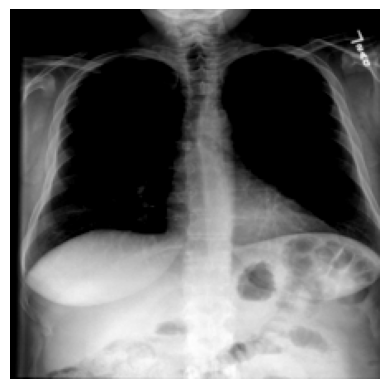



Actual Image and Text


The heart size is within normal limits. Cardiomediastinal contour is normal. There is a right upper lobe nodule measuring 8 mm in diameter. Trachea is midline. The lungs otherwise clear. XXXX and soft tissues are unremarkable.


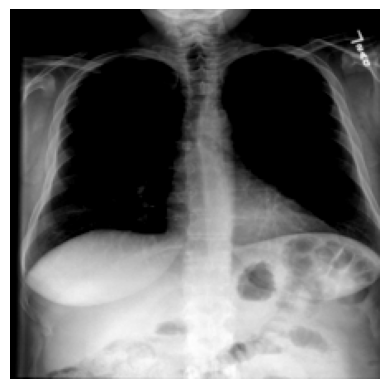

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 41: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


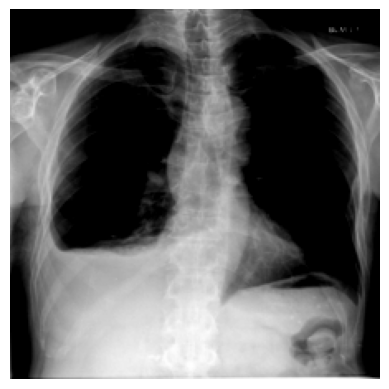



Actual Image and Text


Normal cardiac contour. Right sided pleural effusion. Clear left lung XXXX. No pneumothorax.


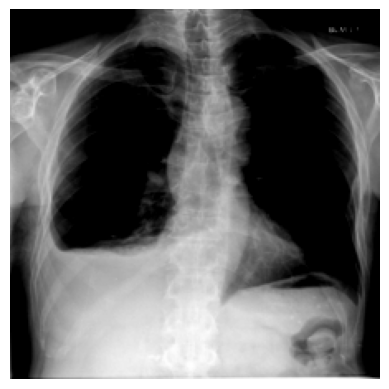

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 42: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


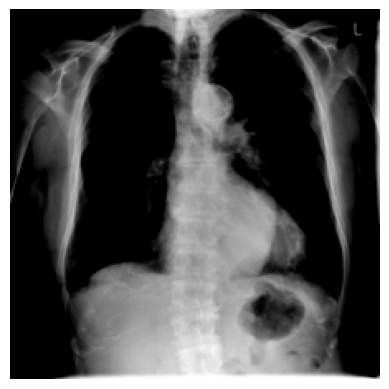



Actual Image and Text


Borderline cardiac enlargement. Enlarged calcified thoracic aorta. Emphysema. No acute pulmonary abnormality. Mild spondylosis.


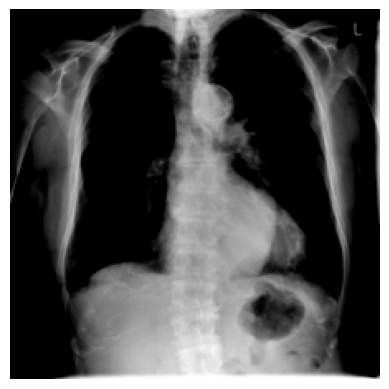

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 43: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


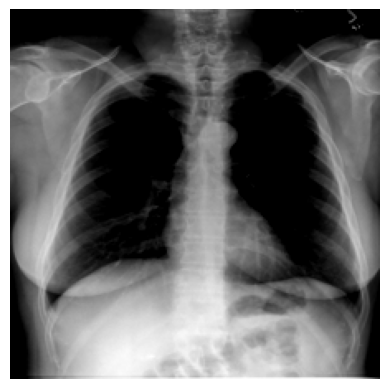



Actual Image and Text


Heart size normal. No pleural effusions or pneumothorax. Lungs are clear. Soft tissues and XXXX are unremarkable.


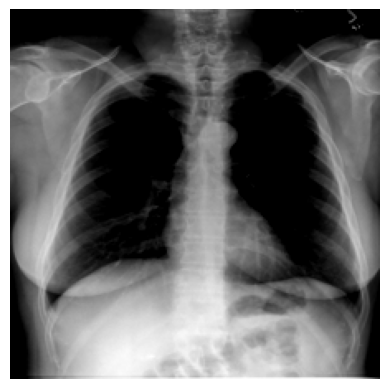

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 44: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


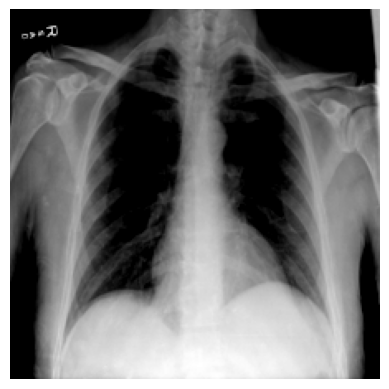



Actual Image and Text


Heart size within normal limits. No focal airspace consolidations. No pneumothorax or effusions.


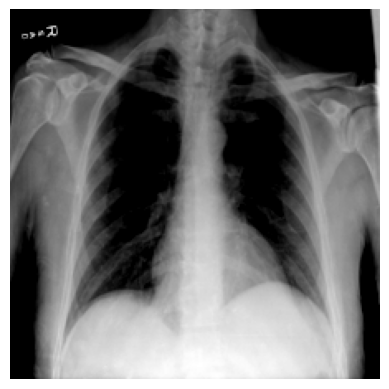

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 45: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


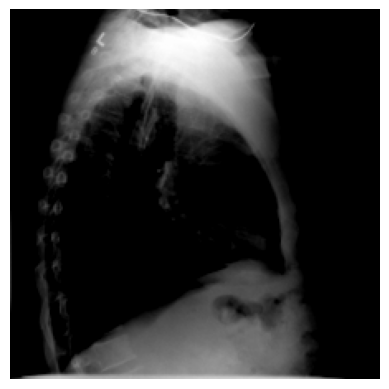



Actual Image and Text


The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.


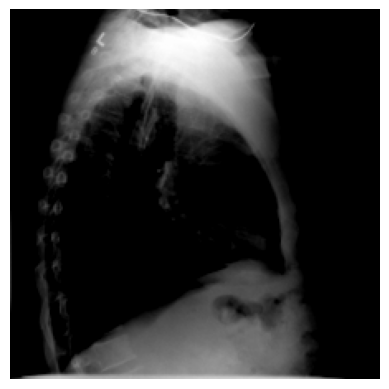

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 46: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


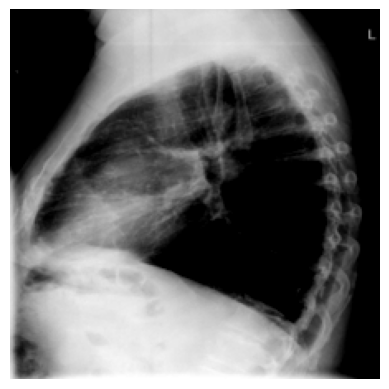



Actual Image and Text


Heart size is normal. There is tortuosity of the thoracic aorta, stable compared with prior. No focal airspace disease or effusion. No pleural effusions or pneumothoraces. Degenerative changes in the thoracic spine.


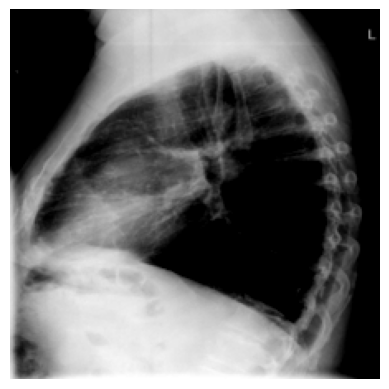

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 47: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


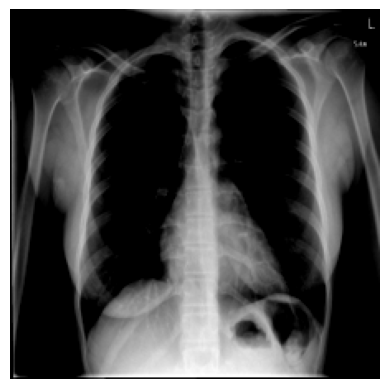



Actual Image and Text


Heart size is within normal limits. No focal airspace consolidations. No pneumothorax or pleural effusion.


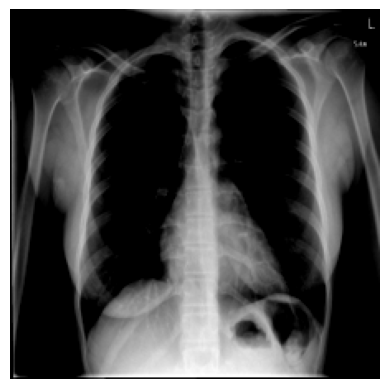

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 48: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


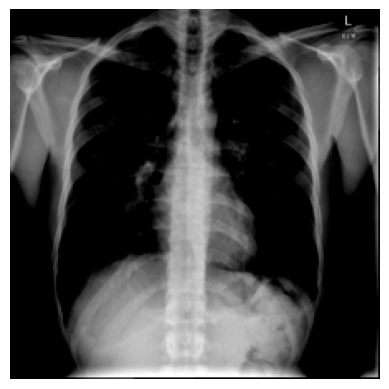



Actual Image and Text


Normal heart. Clear lungs. No pneumothorax. No pleural effusion.


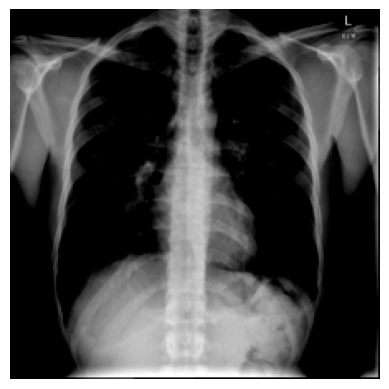

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



----------------------------------------------------------------

Prediction for index 49: The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.


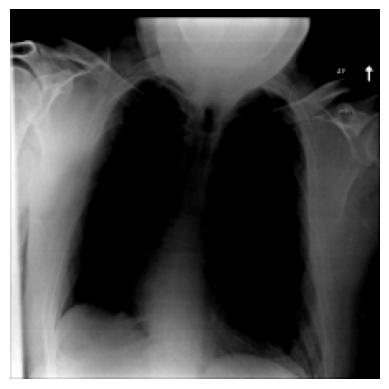



Actual Image and Text


The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.


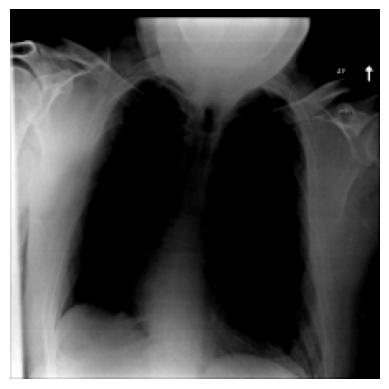


----------------------------------------------------------------



In [18]:
import matplotlib.pyplot as plt
import torch

# Assuming you have a loop 
for idx in range(40, 50):
    inputs = val_ds[idx]['pixel_values']
    with torch.no_grad():
        # Model prediction 
        out = loaded_mode.generate(
            inputs.unsqueeze(0).to('cuda'),  # Move inputs to GPU
            num_beams=4,
            max_length=512
        )

    # Convert token ids to string format
    decoded_out = tokenizer.decode(out[0], skip_special_tokens=True)

    # Display the result
    print(f"Prediction for index {idx}: {decoded_out}")

    # Display the image
    plt.figure()
    plt.axis('off')
    plt.imshow(torch.permute(inputs, (1, 2, 0)))
    plt.show()

    print("\n\nActual Image and Text\n\n")
    # Display the text
    labels_tensor = val_ds[idx]['labels']

    decoded_out = tokenizer.decode(labels_tensor, skip_special_tokens=True)

    print(decoded_out)

    # Display actual image
    inputs = val_ds[idx]['pixel_values']

    # Convert the PyTorch tensor to a NumPy array
    image_array = inputs.permute(1, 2, 0).numpy()
    # Display the image using matplotlib
    plt.figure()
    plt.axis('off')
    plt.imshow(image_array)
    plt.show()


    print("\n----------------------------------------------------------------\n")

In [19]:
import cv2
import matplotlib.pyplot as plt
import torch

# # **comparision between cnn and vit model**

In [20]:
images_captions_df.head()

,imgs,captions
0,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
2,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
3,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
4,/kaggle/input/chest-xrays-indiana-university/i...,There are diffuse bilateral interstitial and a...


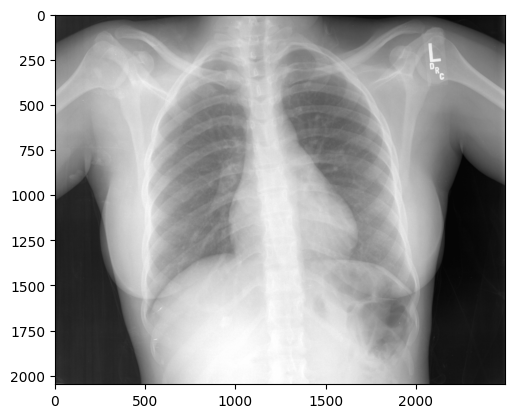

In [21]:
img=cv2.imread(images_captions_df["imgs"][0])
plt.imshow(img)

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import ViTModel, ViTConfig


In [23]:
class XRayDataset(Dataset):
    def __init__(self, image_paths, summaries, transform=None):
        self.image_paths = image_paths
        self.summaries = summaries
        self.transform = transform
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        summary = self.summaries[idx]
        summary_tokens = self.tokenizer(summary, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

        return image, summary_tokens['input_ids'], summary_tokens['attention_mask']


In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [25]:
class ViTGPT2Model(nn.Module):
    def __init__(self):
        super(ViTGPT2Model, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.fc = nn.Linear(self.vit.config.hidden_size, self.gpt2.config.n_embd)

    def forward(self, image, input_ids, attention_mask):
        vit_output = self.vit(pixel_values=image).pooler_output
        vit_output = self.fc(vit_output)
        vit_output = vit_output.unsqueeze(1).repeat(1, input_ids.size(1), 1)

        gpt2_inputs_embeds = self.gpt2.transformer.wte(input_ids) + vit_output

        gpt2_output = self.gpt2(inputs_embeds=gpt2_inputs_embeds, attention_mask=attention_mask, labels=input_ids)

        return gpt2_output.loss, gpt2_output.logits


In [26]:
images_captions_df

,imgs,captions
0,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
2,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
3,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
4,/kaggle/input/chest-xrays-indiana-university/i...,There are diffuse bilateral interstitial and a...
...,...,...
6464,/kaggle/input/chest-xrays-indiana-university/i...,The cardiomediastinal silhouette and pulmonary...
6465,/kaggle/input/chest-xrays-indiana-university/i...,The lungs are clear. Heart size is normal. No ...
6466,/kaggle/input/chest-xrays-indiana-university/i...,The lungs are clear. Heart size is normal. No ...
6467,/kaggle/input/chest-xrays-indiana-university/i...,"Heart size within normal limits. Small, nodula..."


In [27]:
# Set the padding token to be the same as the end-of-sequence token
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token


In [28]:
dataset = XRayDataset(dataframe=images_captions_df, image_column='imgs', summary_column='captions', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


TypeError: XRayDataset.__init__() got an unexpected keyword argument 'dataframe'

In [ ]:
class XRayDataset(Dataset):
    def __init__(self, dataframe, image_column, summary_column, transform=None):
        self.dataframe = dataframe
        self.image_column = image_column
        self.summary_column = summary_column
        self.transform = transform
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token  # Set the padding token

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx][self.image_column]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        summary = self.dataframe.iloc[idx][self.summary_column]
        summary_tokens = self.tokenizer(summary, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

        return image, summary_tokens['input_ids'], summary_tokens['attention_mask']


In [ ]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for images, input_ids, attention_masks in dataloader:
            images = images.to(device)
            input_ids = input_ids.squeeze(1).to(device)
            attention_masks = attention_masks.squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(images, input_ids, attention_masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        loss_values.append(total_loss/len(dataloader))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

# Assuming you have a DataLoader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTGPT2Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Example: 
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
train_model(model, dataloader, optimizer, criterion, num_epochs=5)


In [ ]:
import torch

# Save the entire model
torch.save(model, '/kaggle/vit_gpt2_model.pth')

# OR, save just the model's state_dict
torch.save(model.state_dict(), '/kaggle/vit_gpt2_model_state_dict.pth')


In [ ]:
import torch

# Load model trained 
FILE = '/kaggle/input/visionencoderdecoder-final/model.pth'
model = torch.load(FILE)
# loaded_mode.eval()

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel
from torchvision import models

In [ ]:
# Load the saved model weights
model_path = '/kaggle/input/visionencoderdecoder-final/model.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


In [ ]:
def predict_summary(model, image_path, tokenizer, max_length=128):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        vit_output = model.vit(pixel_values=image).pooler_output
        vit_output = model.fc(vit_output)
        vit_output = vit_output.unsqueeze(1)

        generated_ids = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)

        for _ in range(max_length):
            gpt2_inputs_embeds = model.gpt2.transformer.wte(generated_ids) + vit_output
            outputs = model.gpt2(inputs_embeds=gpt2_inputs_embeds)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(0)
            generated_ids = torch.cat((generated_ids, next_token_id), dim=1)

            if next_token_id == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated_ids.squeeze().tolist(), skip_special_tokens=True)

# model1=
summary = predict_summary(model, images_captions_df["imgs"][0], tokenizer)
print(summary)


In [ ]:
images_captions_df["captions"][0]

In [ ]:
rogue_score=[]

In [ ]:
from rouge_score import rouge_scorer

def calculate_rouge(reference, prediction):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, prediction)
    return scores

# Example usage
reference_summary = summary
predicted_summary = images_captions_df["captions"][1]

rouge_scores = calculate_rouge(reference_summary, predicted_summary)
rogue_score.append(rouge_scores)
print("ROUGE Scores:", rouge_scores)


In [ ]:
# pip install datasets transformers
!pip install rouge-score nltk


In [ ]:
!pip install rouge-score
!pip install sacrebleu


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datasets import load_metric

class ViTGPT2Model(nn.Module):
    def __init__(self):
        super(ViTGPT2Model, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.fc = nn.Linear(self.vit.config.hidden_size, self.gpt2.config.n_embd)

    def forward(self, image, input_ids, attention_mask):
        vit_output = self.vit(pixel_values=image).pooler_output
        vit_output = self.fc(vit_output)
        vit_output = vit_output.unsqueeze(1).repeat(1, input_ids.size(1), 1)

        gpt2_inputs_embeds = self.gpt2.transformer.wte(input_ids) + vit_output

        gpt2_output = self.gpt2(
            inputs_embeds=gpt2_inputs_embeds,
            attention_mask=attention_mask,
            labels=input_ids
        )

        return gpt2_output.loss, gpt2_output.logits

def compute_metrics(predictions, references):
    rouge = load_metric('rouge')
    bleu = load_metric('bleu')

    decoded_preds = predictions.argmax(dim=-1).tolist()
    decoded_refs = references.tolist()

    # Convert to strings
    decoded_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in decoded_preds]
    decoded_refs = [[tokenizer.decode(ref, skip_special_tokens=True)] for ref in decoded_refs]

    # Compute ROUGE score
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_refs)
    # Compute BLEU score
    bleu_result = bleu.compute(predictions=decoded_preds, references=decoded_refs)

    return rouge_result, bleu_result

def train_model(model, dataloader, optimizer, criterion, tokenizer, num_epochs=5):
    model.train()
    loss_values = []
    accuracy_values = []
    rouge_scores = []
    bleu_scores = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        all_preds = []
        all_refs = []

        for images, input_ids, attention_masks in dataloader:
            images = images.to(device)
            input_ids = input_ids.squeeze(1).to(device)
            attention_masks = attention_masks.squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(images, input_ids, attention_masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Accuracy
            predictions = logits.argmax(dim=-1)
            correct_predictions += (predictions == input_ids).sum().item()
            total_predictions += input_ids.numel()

            all_preds.append(predictions)
            all_refs.append(input_ids)

        epoch_loss = total_loss / len(dataloader)
        epoch_accuracy = correct_predictions / total_predictions

        loss_values.append(epoch_loss)
        accuracy_values.append(epoch_accuracy)

        # Concatenate all predictions and references
        all_preds = torch.cat(all_preds, dim=0)
        all_refs = torch.cat(all_refs, dim=0)

        # Calculate ROUGE and BLEU scores
#         rouge_result, bleu_result = compute_metrics(all_preds, all_refs)
#         rouge_scores.append(rouge_result)
#         bleu_scores.append(bleu_result)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
#         print(f'ROUGE Score: {rouge_result}')
#         print(f'BLEU Score: {bleu_result}')

    # Plot loss and accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()

    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'vit_gpt2_model.pth')
    print('Model saved to vit_gpt2_model.pth')

# Assuming you have a DataLoader ready
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTGPT2Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Example: 
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
train_model(model, dataloader, optimizer, criterion, tokenizer, num_epochs=10)


# cnn implementation

In [ ]:
images_captions_df.head()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Ensure reproducibility
torch.manual_seed(42)

# Load the data
df = images_captions_df # Replace with your actual dataset path

# Assume df has 'image_path' and 'summary' columns
image_paths = df['imgs'].values
summaries = df['captions'].values


In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
max_len = 50  # Maximum length for summary tokens

# Custom dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_paths, summaries, transform, tokenizer, max_len):
        self.image_paths = image_paths
        self.summaries = summaries
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and preprocess image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        
        # Tokenize summary
        summary = self.summaries[idx]
        tokens = self.tokenizer(summary, return_tensors="pt", truncation=True, padding='max_length', max_length=self.max_len)
        input_ids = tokens['input_ids'].squeeze()
        attention_mask = tokens['attention_mask'].squeeze()
        
        return image, input_ids, attention_mask

# Create dataset
dataset = ImageCaptionDataset(image_paths, summaries, transform, tokenizer, max_len)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel
from torchvision import models

# Recreate the Model Architecture
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn_encoder, gpt2_decoder, embedding_dim):
        super(ImageCaptioningModel, self).__init__()
        self.vit = cnn_encoder
        self.fc = nn.Linear(cnn_encoder_output_dim, embedding_dim)
        self.gpt2 = gpt2_decoder
    
    def forward(self, images, captions, attention_mask):
        # Encode the images
        vit_output = self.vit(images)
        vit_output = self.fc(vit_output).unsqueeze(1)
        
        # Prepare the inputs for GPT-2
        gpt2_inputs_embeds = self.gpt2.transformer.wte(captions) + vit_output
        
        # Generate the summary
        outputs = self.gpt2(inputs_embeds=gpt2_inputs_embeds, attention_mask=attention_mask)
        return outputs.logits

# Recreate the CNN and GPT-2 components
cnn_encoder = models.resnet50(pretrained=False)  # Pretrained set to False since we will load custom weights

# Save the output dimension before replacing the final layer
cnn_encoder_output_dim = cnn_encoder.fc.in_features

cnn_encoder.fc = nn.Identity()  # Remove the final classification layer

gpt2_decoder = GPT2LMHeadModel.from_pretrained('gpt2')

# Define the combined model
embedding_dim = gpt2_decoder.config.n_embd
model = ImageCaptioningModel(cnn_encoder, gpt2_decoder, embedding_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model weights
model_path = 'vit_gpt2_model.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))


In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn_encoder, gpt2_decoder, embedding_dim):
        super(ImageCaptioningModel, self).__init__()
        self.cnn_encoder = cnn_encoder
        self.linear = nn.Linear(cnn_encoder.fc.in_features, embedding_dim)
        self.gpt2_decoder = gpt2_decoder
    
    def forward(self, images, captions, attention_mask):
        # Encode the images
        cnn_features = self.cnn_encoder(images)
        image_embeddings = self.linear(cnn_features).unsqueeze(1)
        
        # Prepare the inputs for GPT-2
        decoder_input = torch.cat([image_embeddings, captions[:, :-1]], dim=1)
        
        # Generate the summary
        outputs = self.gpt2_decoder(inputs_embeds=decoder_input, attention_mask=attention_mask[:, :-1])
        return outputs.logits

# Load pre-trained models
cnn_encoder = models.resnet50(pretrained=True)
cnn_encoder.fc = nn.Identity()  # Remove the final classification layer

gpt2_decoder = GPT2LMHeadModel.from_pretrained('gpt2')

# Define the combined model
embedding_dim = gpt2_decoder.config.n_embd
model = ImageCaptioningModel(cnn_encoder, gpt2_decoder, embedding_dim).to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def train_and_evaluate(model, train_loader, test_loader, epochs, learning_rate):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Tracking metrics
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, input_ids, attention_mask in tqdm(train_loader):
            images, input_ids, attention_mask = images.to('cuda'), input_ids.to('cuda'), attention_mask.to('cuda')
            
            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            
            # Compute loss
            loss = criterion(outputs.view(-1, outputs.size(-1)), input_ids[:, 1:].reshape(-1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, input_ids, attention_mask in test_loader:
                images, input_ids, attention_mask = images.to('cuda'), input_ids.to('cuda'), attention_mask.to('cuda')
                
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs.view(-1, outputs.size(-1)), input_ids[:, 1:].reshape(-1))
                
                running_loss += loss.item()
        
        avg_test_loss = running_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Print metrics
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

# Train and evaluate the model
epochs = 10
learning_rate = 1e-4
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, epochs, learning_rate)


In [ ]:
# Save the trained model
model_path = 'image_captioning_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
